In [45]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, classification_report, average_precision_score, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
import xgboost as xgb

In [2]:
os.chdir('F:/Python/Projects/IBM laundering project')

In [3]:
df = pd.read_parquet('cleaned_data.parquet', engine="pyarrow")
df[['from bank', 'to bank']] = df[['from bank', 'to bank']].astype('category')
df.drop(df[['amount received', 'amount paid']], axis=1, inplace=True)

In [4]:
def make_new_features(data):
    data = time_features(data)
    data = account_features(data)
    data = curr_format_features(data)
    data = delta_features(data)
    data = change_format(data)
    return data


def time_features(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['day'] = data['timestamp'].dt.day
    data['hour'] = data['timestamp'].dt.hour
    data['minute'] = data['timestamp'].dt.minute
    data['day_cos'] = np.cos(data['day'])
    data['day_sin'] = np.sin(data['day'])
    data['hour_cos'] = np.cos(data['hour'])
    data['hour_sin'] = np.sin(data['hour'])
    data['minute_cos'] = np.cos(data['minute'])
    data['minute_sin'] = np.sin(data['minute'])
    data.drop("timestamp", inplace=True, axis=1)
    
    return data

def account_features(data):
    acc_send = pd.DataFrame(df.groupby("account")["received_in_usd"].agg("median")).rename({"received_in_usd": "median_of_acc_sendings"}, axis=1).reset_index()
    acc_rec = pd.DataFrame(df.groupby("account.1")["received_in_usd"].agg("median")).rename({"received_in_usd": "median_of_acc_receivings"}, axis=1).reset_index()
    acc_rec.rename({"account.1": "account"}, inplace=True, axis=1)
    new_features = acc_send.merge(acc_rec, on="account", how="left")

    acc_send_mean = pd.DataFrame(df.groupby("account")["received_in_usd"].agg("mean")).rename({"received_in_usd": "mean_of_acc_sendings"}, axis=1).reset_index()
    acc_rec_mean = pd.DataFrame(df.groupby("account.1")["received_in_usd"].agg("mean")).rename({"received_in_usd": "mean_of_acc_receivings"}, axis=1).reset_index()
    acc_rec_mean.rename({"account.1": "account"}, inplace=True, axis=1)
    new_features2 = acc_send_mean.merge(acc_rec_mean, on="account", how="left")

    new_feats = new_features.merge(new_features2, on="account", how="left")
    for col in new_feats.columns:
        if new_feats[col].isna().sum() > 0:
            new_feats.fillna(0, inplace=True)
    data = data.merge(new_feats, on="account", how="left")
    
    return data
    
def curr_format_features(data):    

    means_curr_format = pd.DataFrame(df.groupby(["receiving currency", "payment format"])["received_in_usd"].agg("mean")).rename({"received_in_usd": "mean_curr_format"}, axis=1).reset_index()

    medians_curr_format = pd.DataFrame(df.groupby(["receiving currency", "payment format"])["received_in_usd"].agg("median")).rename({"received_in_usd": "median_curr_format"}, axis=1).reset_index()

    new_feats2 = medians_curr_format.merge(means_curr_format, on=["receiving currency", "payment format"], how="left")
    for col in new_feats2.columns:
        if new_feats2[col].isna().sum() > 0:
            new_feats2.fillna(0, inplace=True)
    data = data.merge(new_feats2, on=["receiving currency", "payment format"], how="left")
    
    return data

def delta_features(data):
    data["rec_send_diff_median"] = np.abs(data["median_of_acc_receivings"] - data["median_of_acc_sendings"])
    data["rec_send_diff_mean"] = np.abs(data["mean_of_acc_receivings"] - data["mean_of_acc_sendings"])
    data["received_paid_diff"] = np.abs(data["paid_in_usd"]) - np.abs(data["received_in_usd"])
    
    return data

def change_format(data):
    for col in data.columns:
        try:
            if np.dtype(data[col]) == 'O':
                data[col] = data[col].astype('category')
        except:
            pass
        try:
            if np.dtype(data[col]) == 'int64':
                data[col] = data[col].astype('int32')
        except:
            pass
        
        try:
            if np.dtype(data[col]) == 'float64':
                data[col] = data[col].astype('float32')
        except:
            pass
    return data

In [5]:
mean_norm = df[df['is laundering'] == 0]['received_in_usd'].mean()
median_norm = df[df['is laundering'] == 0]['received_in_usd'].median()

mean_laun = df[df['is laundering'] == 1]['received_in_usd'].mean()
median_laun = df[df['is laundering'] == 1]['received_in_usd'].median()

In [7]:
y = df['is laundering']
y.reset_index(drop=True, inplace=True)
df.drop('is laundering', axis=1, inplace=True)
X = df

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [8]:
X_train = make_new_features(X_train)
X_val = make_new_features(X_val)

In [9]:
X_train.columns

Index(['from bank', 'account', 'to bank', 'account.1', 'receiving currency',
       'payment currency', 'payment format', 'received_in_usd', 'paid_in_usd',
       'day', 'hour', 'minute', 'day_cos', 'day_sin', 'hour_cos', 'hour_sin',
       'minute_cos', 'minute_sin', 'median_of_acc_sendings',
       'median_of_acc_receivings', 'mean_of_acc_sendings',
       'mean_of_acc_receivings', 'median_curr_format', 'mean_curr_format',
       'rec_send_diff_median', 'rec_send_diff_mean', 'received_paid_diff'],
      dtype='object')

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import CountEncoder

SS = StandardScaler()

CE = CountEncoder(cols=['from bank', 'to bank',  
                          'receiving currency','payment format',
                          'payment currency', 'account', 'account.1'], normalize=True
                 )
preprocessor = ColumnTransformer(
    transformers = [('scaler', SS, ['received_in_usd', 'paid_in_usd', "median_of_acc_sendings",
                                     "median_of_acc_receivings", "mean_of_acc_sendings",
                                     "mean_of_acc_receivings", "median_curr_format", 
                                     "mean_curr_format", "rec_send_diff_median", 
                                     "rec_send_diff_mean", "received_paid_diff"])],
                    remainder='passthrough')

model = xgb.XGBClassifier(n_estimators=1000,
                          max_depth=15,
                          eta=0.08,
                          tree_method='gpu_hist',
                          min_child_weight=3,
                          reg_lambda=0.00001,
                          colsample_bytree=1.0)

pipe = Pipeline(steps=[('enc', CE), 
                       ('prep', preprocessor),
                       ('model', model)])

In [12]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('enc',
                 CountEncoder(cols=['from bank', 'to bank',
                                    'receiving currency', 'payment format',
                                    'payment currency', 'account',
                                    'account.1'],
                              combine_min_nan_groups=True, normalize=True)),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['received_in_usd',
                                                   'paid_in_usd',
                                                   'median_of_acc_sendings',
                                                   'median_of_acc_re...
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=3, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [13]:
def get_metrics(target, preds):
    results = {
        "Roc_auc": roc_auc_score(target, preds),
        "F1": f1_score(target, preds),
        "Precision": precision_score(target, preds),
        "Recall": recall_score(target, preds),
        "Confusion matrix": confusion_matrix(target, preds)
    }
    return results

def get_report_and_roc_curve(target, preds):
    class_report = classification_report(target, preds)
    fpr, tpr, thresholds = roc_curve(target, preds)
    print(class_report)
    plt.plot(fpr, tpr)
    plt.xlabel('False positive')
    plt.ylabel('True positive')
    plt.show()

In [14]:
preds_val = pipe.predict_proba(X_val)[:, 1]
preds_val = np.where(preds_val>=0.1, 1, 0)
# I use threshold because I don't want many false positives

In [15]:
get_metrics(y_val, preds_val)

{'Roc_auc': 0.7127756886030984,
 'F1': 0.5263157894736843,
 'Precision': 0.6891025641025641,
 'Recall': 0.42574257425742573,
 'Confusion matrix': array([[507233,     97],
        [   290,    215]], dtype=int64)}

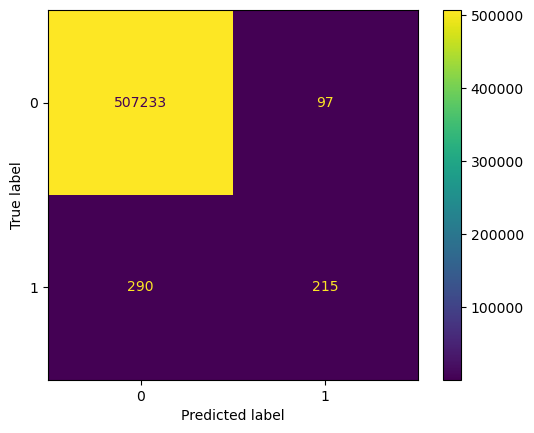

In [46]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, preds_val))
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    507330
           1       0.69      0.43      0.53       505

    accuracy                           1.00    507835
   macro avg       0.84      0.71      0.76    507835
weighted avg       1.00      1.00      1.00    507835



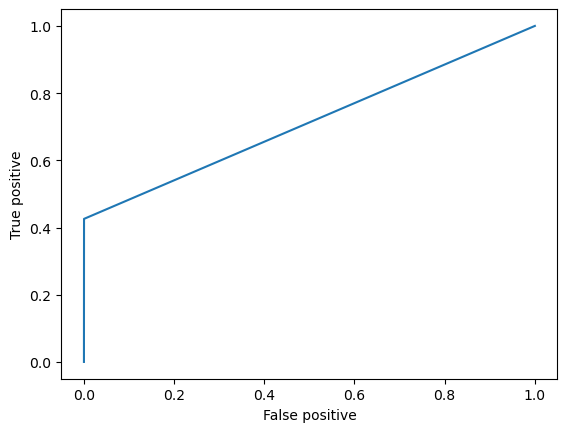

In [16]:
get_report_and_roc_curve(y_val, preds_val)

<AxesSubplot:>

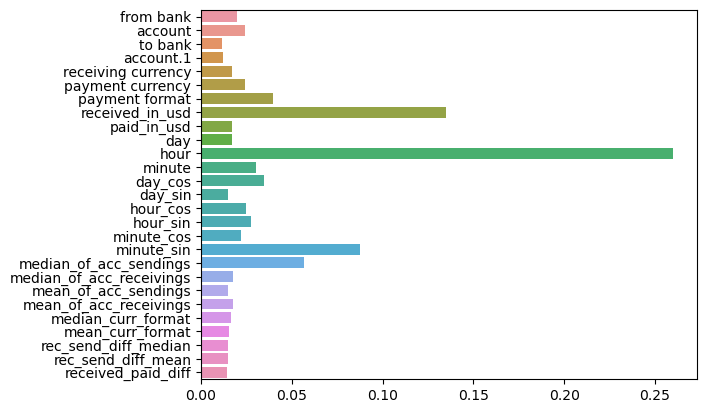

In [20]:
cols = X_train.columns
sns.barplot(x=model.feature_importances_, y=cols, orient='h')

In [22]:
import pickle
with open("pipe.pkl", "wb") as m:
    pickle.dump(pipe, m)

In [26]:
print(f"Mean_norm: {mean_norm}")
print(f"Mean_laun: {mean_laun}")
print("=================================")
print(f"Median_norm: {median_norm}")
print(f"Median_laun: {median_laun}")

Mean_norm: 344241.71875
Mean_laun: 4952431.5
Median_norm: 882.1699829101562
Median_laun: 5840.0498046875


In [37]:
saved_from_detected_laun = median_laun*215
false_positives = median_norm*97 
saved_money = saved_from_detected_laun - false_positives

It depends on situation whether to consider false positives as losses or not, but I decided to do that

In [38]:
print(saved_from_detected_laun)
print(false_positives)
print(saved_money)

1255610.7080078125
85570.48834228516
1170040.2196655273


In [40]:
290*median_laun

1693614.443359375

In [41]:
507233*median_norm

447465726.9414673

Model gives adequate results. Although there is a lot of false negatives, model still can detect 42-45% of laundering transactions and make impact. In order to check efficiency of the model beyond metrics I decided to see how much money model actually can save. For this I used median and to the mean, because data is very skewed. Above we can see that model helps to save 1170040 dollars.